<a href="https://colab.research.google.com/github/paulmyr/DD2365-AdvancedCFD/blob/master/project/code/Euler-equations-compressible-flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Euler equations for compressible flow**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Euler equations using FEM, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [67]:
# This program is an example file for the course
# DD2365 Advanced Computation in Fluid Mechanics,
# KTH Royal Institute of Technology, Stockholm, Sweden,

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License v2.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

# **Set up environment**

In [68]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

Note for me, the Euler equations specified below are in conservation form.

With the notation form Anderson, the continuity, momentum and energy equation:

$
\begin{eqnarray}
\frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{V}) = 0, \\
\frac{\partial m}{\partial t} + \nabla \cdot (m \mathbf{V}) + \nabla p = f, \\
\frac{\partial E}{\partial t} + \nabla \cdot (E \mathbf{V}) + \nabla \cdot(p\mathbf{V})= 0,
\end{eqnarray}
$



The Euler equations take the form

$
\begin{eqnarray}
\dot \rho + \nabla \cdot (u \rho) = 0, \\
\dot m + \nabla \cdot (u m) + \nabla p = f, \\
\dot E + \nabla \cdot (u E) + \nabla \cdot(up)= 0,
\end{eqnarray}
$

together with suitable initial and boundary conditions.

Here velocity is given by

$u = \frac{m}{\rho},$

and for a perfect gas, the pressure is given by

$p = (\gamma - 1)(E-\frac{\vert u\vert^2}{2}),$

where $\gamma = 1.4$ is the specific heat ratio for air, and we get the temperature,

$T = \frac{E}{\rho} - \frac{\vert u\vert^2}{2},$

the speed of sound,

$\sqrt{\gamma(\gamma-1)T},$

and the Mach number,

$M = \frac{\vert u\vert }{c}.$

Here we present a FEniCS implementation of a stabilized finite element method to solve the Euler equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

- [Link to medium article](https://levelup.gitconnected.com/create-your-own-finite-volume-fluid-simulation-with-python-8f9eab0b8305)

# **Method**

**Define domain and mesh**

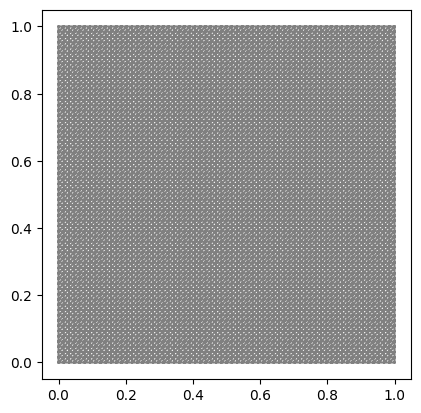

In [69]:
# Define rectangular domain
L = 1.0
H = 1.0

# Define circle
# xc = 0.8
# yc = 0.5*H
# rc = 0.2

# Specific heat ratio for air
gamma = 1.4

# Generate mesh (examples with and without a hole in the mesh)
resolution = 64
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), int(L*resolution), int(H*resolution))
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

class Object(SubDomain):
    def inside(self, x, on_boundary, L=L, H=H):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

left = Left()
right = Right()
lower = Lower()
upper = Upper()
object = Object()

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)
object.mark(boundaries, 5)

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [70]:
# Generate finite element spaces (for density, momentum, total energy)
R = FunctionSpace(mesh, "Lagrange", 1)
V = VectorFunctionSpace(mesh, "Lagrange", 2)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
r = TrialFunction(R)  # density (rho)
m = TrialFunction(V)  # momentum
E = TrialFunction(Q)  # energy
d = TestFunction(R)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [71]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary, H=H):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeftPassive(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) and abs(x[0] - 0.5) > 0.15

class DirichletBoundaryLeftActive(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) and abs(x[0] - 0.5) <= 0.15

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary, L=L):
        return on_boundary and near(x[0], L)

class DirichletBoundaryRightActive(SubDomain):
    def inside(self, x, on_boundary, L=L):
        return on_boundary and near(x[0], L) and abs(x[0] - 0.5) <= 0.15

class DirichletBoundaryRightPassive(SubDomain):
    def inside(self, x, on_boundary, L=L):
        return on_boundary and near(x[0], L) and abs(x[0] - 0.5) > 0.15

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary, L=L, H=H):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_left_active = DirichletBoundaryLeftActive()
dbc_left_passive = DirichletBoundaryLeftPassive()
dbc_right = DirichletBoundaryRight()
dbc_right_active = DirichletBoundaryRightActive()
dbc_right_passive = DirichletBoundaryRightPassive()
dbc_objects = DirichletBoundaryObjects()


# m_in = Expression('4.0*(abs(x[1] - 0.5))', element = V.sub(0).ufl_element())
m_in_vel = 8.0
m_in = Expression((f"{m_in_vel}", "0.0"), degree=1)
m_in_neg = Expression((f"-1.0 * {m_in_vel}", "0.0"), degree=1)
# m_in = [m_in_vel, 0.0]


bcm_upp = DirichletBC(V, [0.0, 0.0], dbc_upper)
bcm_low = DirichletBC(V, [0.0, 0.0], dbc_lower)
# bcm_left = DirichletBC(V, [0.0, 0.0], dbc_left_passive)
bcm_left_passive = DirichletBC(V, m_in_neg, dbc_left_passive)
bcm_left_active = DirichletBC(V, m_in, dbc_left_active) #

bcm_right_passive = DirichletBC(V, m_in_neg, dbc_right_passive)
bcm_right_active = DirichletBC(V, m_in, dbc_right_active) #

r_in = 1.0
bcr_left = DirichletBC(R, r_in, dbc_left)
# bcr_left_active = DirichletBC(R, r_in, dbc_left_active)
# bcr_left_passive = DirichletBC(R, -1 * r_in, dbc_left_passive)

bcr_right = DirichletBC(R, r_in, dbc_right)

E_in = 2.5
bcE_left = DirichletBC(Q, E_in, dbc_left)
# bcE_left_active = DirichletBC(Q, E_in, dbc_left_active)
# bcE_left_passive = DirichletBC(Q, -1 * E_in, dbc_left_passive)

bcE_right = DirichletBC(Q, E_in, dbc_right)

# bcm = [bcm_in, bcm_left, bcm_upp, bcm_low]
bcm = [bcm_left_active, bcm_left_passive, bcm_upp, bcm_low, bcm_right_active, bcm_right_passive]
bcr = [bcr_left, bcr_right]
bcE = [bcE_left, bcE_right]
#bcr = [bcr_in]
#bcE = [bcE_in]

# **Results**

**Define method parameters**

In [72]:
# Define iteration functions
# *0 solution from previous time step
# *1 linearized solution at present time step
r0 = Function(R)
m0 = Function(V)
E0 = Function(Q)
r1 = Function(R)
m1 = Function(V)
E1 = Function(Q)

eps_cav = 1.0e-6

# Set parameters for nonlinear and linear solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()*(r_in/m_in_vel)

**Define variational problem**

In [73]:
# Define variational problem

# Mean velocities for trapozoidal time stepping
rm = 0.5*(r + r0)
mm = 0.5*(m + m0)
Em = 0.5*(E + E0)

rm1 = 0.5*(r1 + r0)
mm1 = 0.5*(m1 + m0)
Em1 = 0.5*(E1 + E0)

u0 = m0/(r0 + eps_cav)
u1 = m1/(r1 + eps_cav)
um1 = 0.5*(u1 + u0)

# Perfect gas
# gamma = 1.4 # specific heat ratio for air
p1 = (gamma - 1.0)*(E1 - 0.5*inner(m1,m1)/(r1 + eps_cav)) # pressure

# Temperature
Temp = E1/r1 - 0.5*inner(u1, u1)

# Speed of sound
c = sqrt(gamma*(gamma-1.0)*Temp)

# Mach number
Mach = sqrt(inner(u1, u1))/c

# Facet normal
normal = FacetNormal(mesh)

# Local mesh size
h = CellDiameter(mesh);

# Stabilization parameters
u_mag = sqrt(dot(u1,u1))
C1 = 1.0
d1 = C1/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))

# Penalty boundary conditions
C_alpha = 1.0e2
alpha = C_alpha/h

# Residuals
res_r = (r1 - r0)/dt + div(u1)*r1 + inner(grad(r1), u1)
res_m = (m1 - m0)/dt + div(u1)*m1 + grad(m1)*u1 + grad(p1)
res_E = (E1 - E0)/dt + div(u1)*E1 + inner(grad(E1), u1) + div(u1)*p1 + inner(grad(p1), u1)

# Smagorinsky model (simplified)
C_t = 1.0e-2

C_stab = 1.0

#nu_turb = h
#nu_turb = C_t*h*h*sqrt(inner(grad(um1), grad(um1)))
#nu_turb = C_stab*h*h*sqrt(res_r*res_r + inner(res_m, res_m) + res_E*res_E)

nu_r = C_stab*h*h*sqrt(res_r*res_r)/r_in
nu_m = C_stab*h*h*sqrt(inner(res_m, res_m))/m_in[0]
nu_E = C_stab*h*h*sqrt(res_E*res_E)/E_in

# Density variational equation on residual form
Fr = inner((r - r0)/dt, d)*dx - inner(rm*um1, grad(d))*dx \
    + nu_r * inner(grad(rm), grad(d))*dx \
    + inner(dot(um1, normal)*r_in, d)*ds(1) \
    + inner(dot(um1, normal)*rm, d)*ds(2)
    #+ d1*inner((r - r0)/dt + div(u1)*rm + inner(grad(rm), u1), dot(grad(d), u1))*dx \

ar = lhs(Fr)
Lr = rhs(Fr)

# Momentum variational equation on residual form
Fm = inner((m - m0)/dt, v)*dx - inner(outer(mm,um1), grad(v))*dx - p1*div(v)*dx \
        + nu_m * inner(grad(mm), grad(v))*dx \
        + alpha*(inner(dot(mm,normal), dot(v,normal)))*ds(5) \
        + (dot(u1, normal)*inner(m_in, v))*ds(1) \
        + (dot(u1, normal)*inner(mm, v))*ds(2)
        #+ d1*inner((m - m0)/dt + div(u1)*mm + grad(mm)*u1 + grad(p1), grad(v)*u1)*dx \

am = lhs(Fm)
Lm = rhs(Fm)

# Density variational equation on residual form
FE = inner((E - E0)/dt, q)*dx - inner(Em*um1, grad(q))*dx \
    + nu_E * inner(grad(Em), grad(q))*dx \
    + inner(dot(um1, normal)*E_in, q)*ds(1) \
    + inner(dot(um1, normal)*Em, q)*ds(2)
    #+ d1*inner((E - E0)/dt + div(u1)*Em + inner(grad(Em), u1) + div(u1)*p1 + inner(grad(p1), u1), dot(grad(q), u1))*dx \

aE = lhs(FE)
LE = rhs(FE)

**Compute force on boundary**

In [74]:
# Velocity
u1 = m1/(r1 + eps_cav)

# Perfect gas
p1 = (gamma - 1.0)*(E1 - 0.5*inner(m1,m1)/(r1 + eps_cav)) # pressure

**Set plotting variables and open export files**

In [75]:
# Open files to export solution to Paraview
file_r = File("results-NS/r.pvd")
file_m = File("results-NS/m.pvd")
file_E = File("results-NS/E.pvd")
file_Mach = File("results-NS/Mach.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 200

time = np.array(0.0)
time = np.delete(time, 0)

start_sample_time = 1.0

**Time stepping algorithm**

Time t = 0.0013810679320049757


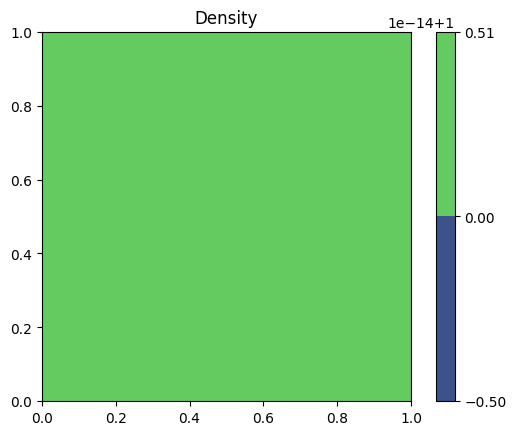

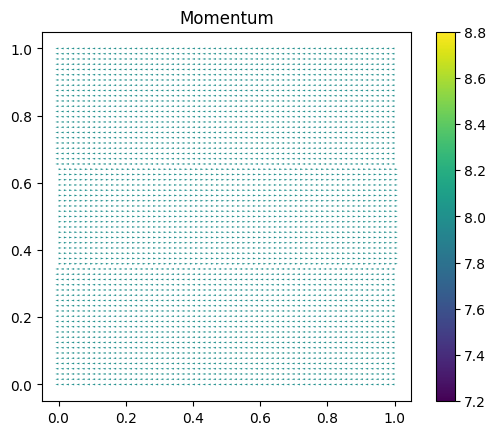

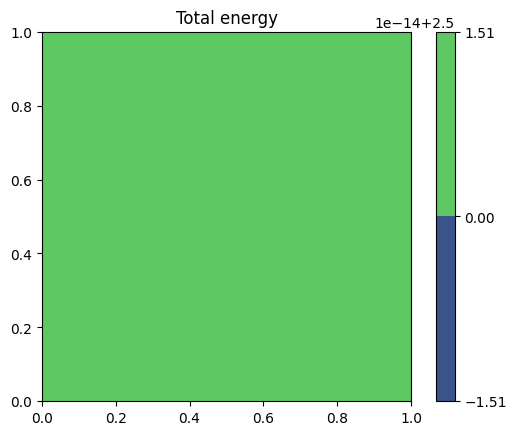

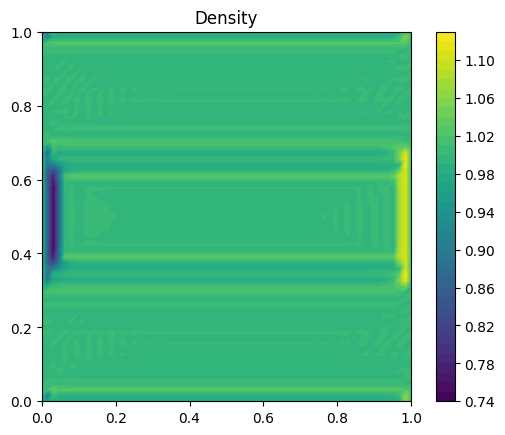

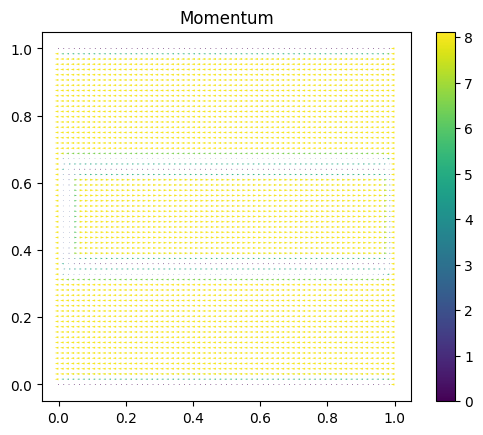

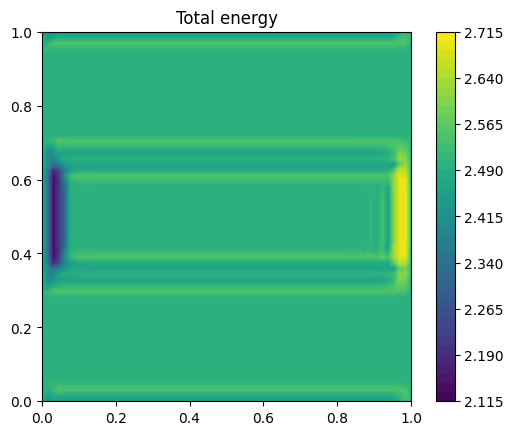

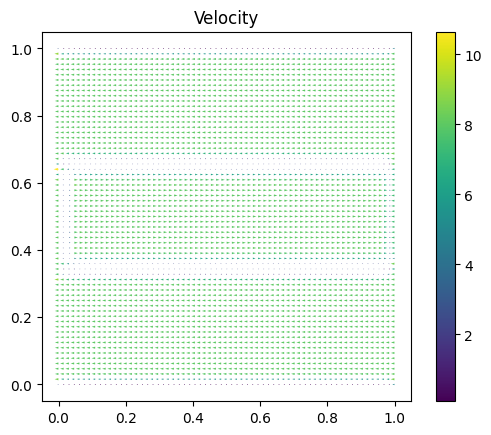

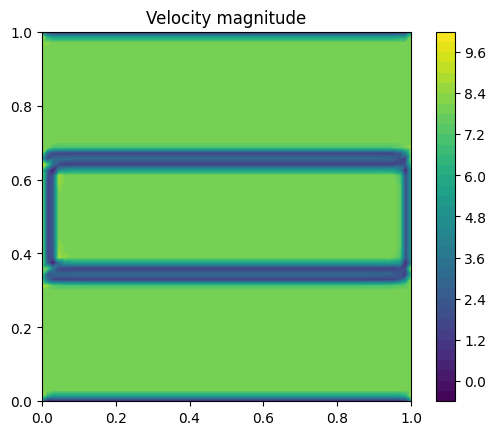

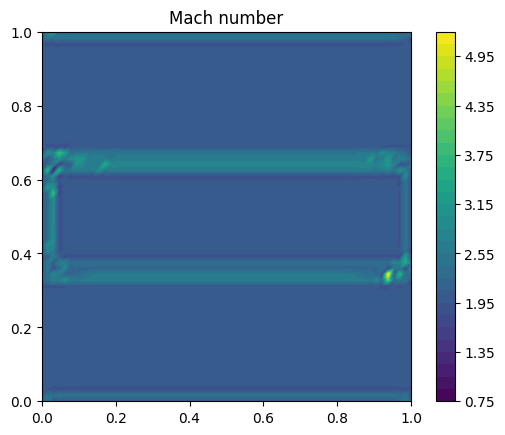

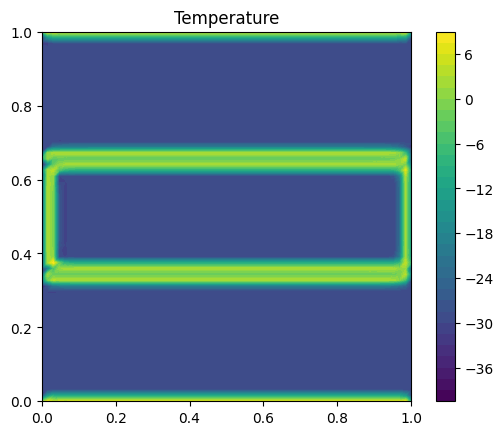

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     https://fenicsproject.discourse.group/
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve linear system using PETSc Krylov solver.
*** Reason:  Solution failed to converge in 2516 iterations (PETSc reason DIVERGED_DTOL, residual norm ||r|| = 2.609875e+07).
*** Where:   This error was encountered inside PETScKrylovSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.2.0.dev0
*** Git changeset:  a8dcf753d3ab9ae19d7bedf8c634a4fe545032d2
*** -------------------------------------------------------------------------


In [76]:
!rm results-NS/*

r0.interpolate(Expression("1.0", degree=1))
m0.interpolate(Expression((f"{m_in_vel} * (abs(x[1] - 0.5) <= 0.15) - {m_in_vel} * (abs(x[1] - 0.5) > 0.15)", "0.0"), degree=1))
# m0.interpolate(Expression((f"{m_in_vel} * (abs(x[1] - 0.5) <= 0.15)", "0.0"), degree=1))
E0.interpolate(Expression("2.5", degree=1))

# Plot solution
plt.figure()
im = plot(r0, title="Density")
plt.colorbar(im)

plt.figure()
im = plot(m0, title="Momentum")
plt.colorbar(im)

plt.figure()
im = plot(E0, title="Total energy")
plt.colorbar(im)

# Time stepping
T = 2
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    #pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble density matrix and vector
        Ar = assemble(ar)
        br = assemble(Lr)

        # Compute density solution
        [bc.apply(Ar, br) for bc in bcr]
        [bc.apply(r1.vector()) for bc in bcr]
        solve(Ar, r1.vector(), br, "bicgstab", "default")

        # Assemble momentum matrix and vector
        Am = assemble(am)
        bm = assemble(Lm)

        # Compute momentum solution
        [bc.apply(Am, bm) for bc in bcm]
        [bc.apply(m1.vector()) for bc in bcm]
        solve(Am, m1.vector(), bm, "bicgstab", "default")

        # Slip boundary condition
        #bcm_slip_0 = m1[0] - dot(m1, node_normal)*node_normal[0]
        #bcm_slip_1 = m1[1] - dot(m1, node_normal)*node_normal[1]
        #[bc.apply(m1.vector()) for bc in bcm_slip]

        # Assemble total energy matrix and vector
        AE = assemble(aE)
        bE = assemble(LE)

        # Compute total energy solution
        [bc.apply(AE, bE) for bc in bcE]
        [bc.apply(E1.vector()) for bc in bcE]
        solve(AE, E1.vector(), bE, "bicgstab", "default")

        k += 1

    if t > plot_time or t + dt > T + DOLFIN_EPS:

        s = 'Time t = ' + repr(t)
        print(s)

        u1 = m1 / (r1 + eps_cav)
        Temp = E1/(r1 + eps_cav) - 0.5*inner(u1, u1)
        c = sqrt(gamma*(gamma-1.0)*abs(Temp))
        Mach_number = project(sqrt(inner(u1, u1))/(c + eps_cav), Q)

        # Save solution to file
        file_r << r1
        file_m << m1
        file_E << E1
        file_Mach << Mach_number

        # Plot solution
        plt.figure()
        im = plot(r1, title="Density")
        plt.colorbar(im)

        plt.figure()
        im = plot(m1, title="Momentum")
        plt.colorbar(im)

        plt.figure()
        im = plot(E1, title="Total energy")
        plt.colorbar(im)

        plt.figure()
        im = plot(u1, title="Velocity")
        plt.colorbar(im)

        plt.figure()
        im = plot(sqrt(inner(u1, u1)), title="Velocity magnitude")
        plt.colorbar(im)

        plt.figure()
        im = plot(Mach_number, title="Mach number")
        plt.colorbar(im)

        plt.figure()
        im = plot(Temp, title="Temperature")
        plt.colorbar(im)
        plt.show()

        plot_time += T/plot_freq



    # Update time step
    r0.assign(r1)
    m0.assign(m1)
    E0.assign(E1)
    t += dt

!tar -czvf results-NS.tar.gz results-NS
# files.download('results-NS.tar.gz')

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Euler equations for compressible flow in 2D.